<a href="https://colab.research.google.com/github/mogesTesema/Machine-Learning-Mastery-With-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TensorFlow part 3: scaling up food vision min
We've seen the power of transfer leanring feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101.
our goal is to beat the original food101 paper with 10% of the training (leveraging the power of transfer learning)

In [1]:
# lownload helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py


--2025-10-23 07:48:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-23 07:48:53 (69.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
!nvidia-smi

Thu Oct 23 07:48:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

2025-10-23 07:48:57.567435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761205738.039220      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761205738.164502      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# 101 food class woring with less data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-10-23 07:49:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 173.194.64.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   258MB/s    in 6.3s    

2025-10-23 07:49:24 (245 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("/kaggle/working/101_food_classes_10_percent.zip")
train_dir = "/kaggle/working/101_food_classes_10_percent/train"
test_dir =  "/kaggle/working/101_food_classes_10_percent/test"

In [6]:
walk_through_dir("/kaggle/working/101_food_classes_10_percent/")

There are 2 directories and 0 images in '/kaggle/working/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '/kaggle/working/101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '/kaggle/working/101_food_classes_10_percent/tra

In [7]:
import tensorflow as tf
IMAGE_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMAGE_SIZE,
                                                                                label_mode="categorical",
                                                                                )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.


I0000 00:00:1761205776.708620      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761205776.709412      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes
Here are the steps we're going to take:
*  Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augementaiton right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model(we'll create our own output layer)
* Compile our model
* feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch)                                                                           
                                                                                                                                          
                                                                              
                                                                             

In [8]:
# Create a modelcheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/ckpt/checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               monitor="val_accuracy",
                                                               mode="max",
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               save_freq="epoch"

                                                               )

In [9]:
# Build a headless functional api model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
for index, layer in enumerate(base_model.layers):
  print(index,layer.name,layer.trainable)

0 input_layer True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [11]:
# freeze the model
base_model.trainable = False


In [12]:
# Data augmentation layer
inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name="inputs")
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomHeight(0.2)(x)
x = tf.keras.layers.RandomWidth(0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
# x= tf.keras.layers.Rescaling(0.2)(x) # rescale inputs between 0 and 1 but we don't need rescaling since efficientNet has rescaling built in feature


# setup model architecture with trainable top layers
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Pooling_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax',name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height (RandomHeight)    │ (None, None, 224, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width (RandomWidth)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, None, None, 3)  │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [15]:
# feature extract the model
history_model = model.fit(train_data_all_10_percent,
                          epochs=5,
                          steps_per_epoch=len(train_data_all_10_percent),
                          validation_data=test_data,
                          validation_steps=int(0.15*len(test_data)),
                          callbacks=[checkpoint_callback]
                              )


Epoch 1/5


E0000 00:00:1761205798.233204      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1761205800.787196      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 153ms/step - accuracy: 0.1497 - loss: 3.9845 - val_accuracy: 0.4701 - val_loss: 2.4539
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.4819 - loss: 2.3588 - val_accuracy: 0.5236 - val_loss: 1.9984
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.5485 - loss: 1.9321 - val_accuracy: 0.5546 - val_loss: 1.7945
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.5772 - loss: 1.7312 - val_accuracy: 0.5614 - val_loss: 1.7267
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.6069 - loss: 1.5721 - val_accuracy: 0.5604 - val_loss: 1.6939


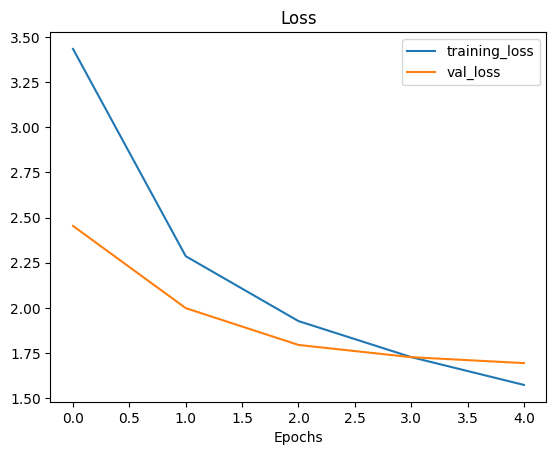

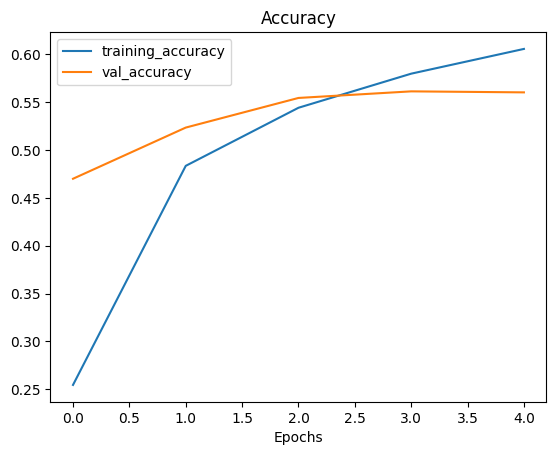

In [16]:
plot_loss_curves(history_model)

In [17]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.5711 - loss: 1.6441


[1.5869356393814087, 0.5832871198654175]

## Fine-tune

In [18]:
# unfreeze top 5 layers in base model
total_layer = len(model.layers[6].layers)
for layer_index in range(total_layer-5,total_layer):
  model.layers[6].layers[layer_index].trainable = True



In [19]:
for index,layer in enumerate(model.layers[6].layers):
  print(index,layer.name,layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
# when we change the internal hyperparameter of the model, we have to recompile otherwise we will stay on the same model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001), # learning rate lowered by 10X,it is best for health
              metrics=["accuracy"])

In [21]:
fine_tune_epochs = 5 + 5
fine_tuned_model_history = model.fit(train_data_all_10_percent,
                                     epochs=fine_tune_epochs,
                                     steps_per_epoch=len(train_data_all_10_percent),
                                     validation_data=test_data,
                                     validation_steps=int(0.15 * len(test_data)),
                                     initial_epoch=history_model.epoch[-1])

Epoch 5/10


E0000 00:00:1761206052.092891      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


237/237 ━━━━━━━━━━━━━━━━━━━━ 53s 155ms/step - accuracy: 0.6200 - loss: 1.5614 - val_accuracy: 0.5575 - val_loss: 1.7052
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.6800 - loss: 1.3366 - val_accuracy: 0.5606 - val_loss: 1.6707
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.6853 - loss: 1.2575 - val_accuracy: 0.5686 - val_loss: 1.6523
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.6998 - loss: 1.2170 - val_accuracy: 0.5662 - val_loss: 1.6394
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - accuracy: 0.7156 - loss: 1.1285 - val_accuracy: 0.5757 - val_loss: 1.6012
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - accuracy: 0.7249 - loss: 1.0871 - val_accuracy: 0.5757 - val_loss: 1.6106


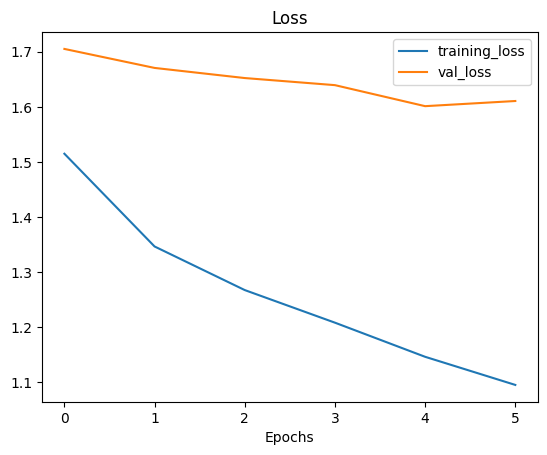

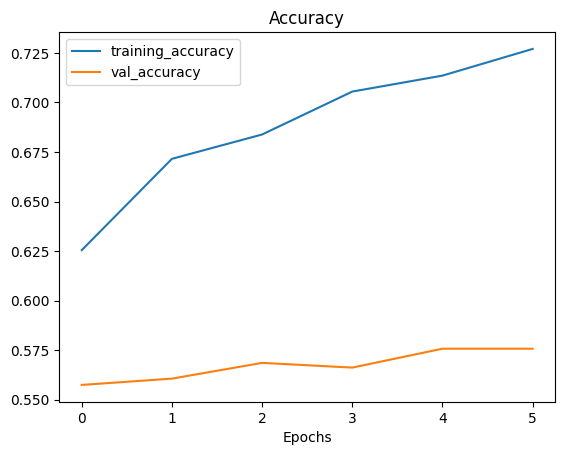

In [22]:
plot_loss_curves(fine_tuned_model_history)

In [23]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.5926 - loss: 1.5291


[1.4228616952896118, 0.6188514828681946]

## Save and loading our model

In [24]:
model.save("big_dog_model.keras")

In [25]:
loaded_model = tf.keras.models.load_model("big_dog_model.keras")

In [26]:
y_preds = loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - accuracy: 0.5926 - loss: 1.5291


In [27]:
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_height (RandomHeight)    │ (None, None, 224, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_width (RandomWidth)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, None, None, 3)  │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,596 (22.89 MB)

 Trainable params: 910,821 (3.47 MB)

 Non-trainable params: 3,268,131 (12.47 MB)

 Optimizer params: 1,821,644 (6.95 MB)

In [28]:
for layer in loaded_model.layers:
    print(layer.name,layer.trainable)

inputs True
random_flip True
random_height True
random_width True
random_rotation True
random_zoom True
efficientnetb0 False
Pooling_layer True
output_layer True


In [29]:
loaded_model.trainable = False

In [30]:
# Create a function to load and prepare images
def load_and_prep_image(filepath,img_shape=224,scale=True):
    """
    Reads an image from filename, turns it into a tensor and reshapes into specified shape(img_shape,img_shape,3)

    Args:
        filepath (str): path to target image
        img_shape (int): height/width dimension fo target iamge size
        scale (bool): scale pixel values from 0-255 to 0-1 or not
    Returns:
        Image tensor fo shape (img_shape,img_shape,3)
    """
    # Read in the image
    img = tf.io.read_file(filepath)
    # print("file read by tf before change to tensor",img,"\n\n\n")
    # Decode image into tensor
    img = tf.io.decode_image(img,channels=3)
    # print(f"image file after change to tensor: {img}")
    # Resize the image
    img = tf.image.resize(img,[img_shape,img_shape])
    # Scale? yes/no
    if scale:
        # Rescale the image,normalization
        return img/255.
    else:
        return img

    

now we've got a function to load and prepare target images,let's now write some code to visualize images,their target label and our model's predictions.
specifically, we'll write some cod to:
1. Load a few random images from the test dataset
2. make predictions on the loaded images
3. plot the original image(s) along with the model's predictions. prediction probability  and truth label

/kaggle/working/101_food_classes_10_percent/test/bibimbap/522225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
/kaggle/working/101_food_classes_10_percent/test/garlic_bread/2592760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/kaggle/working/101_food_classes_10_percent/test/hamburger/593030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


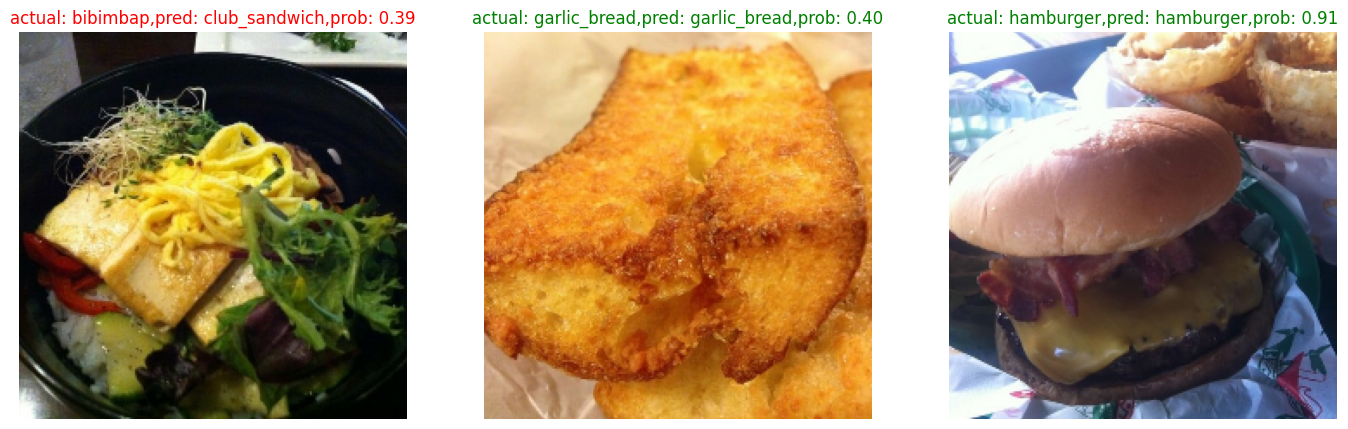

In [31]:
# Make preds on a serious of random images
import os
import random
import matplotlib.pyplot as plt
class_names = train_data_all_10_percent.class_names
plt.figure(figsize=(17,10))
for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = os.path.join(test_dir,class_name,filename)
    print(filepath)
    # load the image and make prediction
    img = load_and_prep_image(filepath,scale=False)
    expanded_img = tf.expand_dims(img,axis=0)
    pred_prob = loaded_model.predict(expanded_img)
    pred_class = class_names[pred_prob.argmax()]
    # print(pred_prob)
    # print(pred_class)
    img = img/255.
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name},pred: {pred_class},prob: {pred_prob.max():.2f}",c=title_color)
    plt.axis(False)

                            
    
